In [ ]:
!pip3 install keras==2.1.0

  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import keras as k
print(tf.test.gpu_device_name())
print('tensorflow = ', tf.__version__) 
print('keras = ', k.__version__)
tf.disable_eager_execution()
import os 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import cv2, urllib
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, Dropout, Lambda
import multiprocessing as mp

TensorFlow 1.x selected.


Using TensorFlow backend.



tensorflow =  1.15.2
keras =  2.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mask_RCNN Model files
!cp -r '/content/drive/MyDrive/fashion_data/Mask_RCNN/mrcnn' 'mrcnn'

## Weights
!cp /content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest22.hd5.index /content/triplet_weights_latest22.hd5.index
!cp /content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest22.hd5.data-00000-of-00002 /content/triplet_weights_latest22.hd5.data-00000-of-00002
!cp /content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest22.hd5.data-00001-of-00002 /content/triplet_weights_latest22.hd5.data-00001-of-00002
!cp /content/drive/MyDrive/fashion_data/fashion_weights2/mask_rcnn_fashion_0024.h5 /content/mask_weights.h5

## Useful csv files and image to be tested
!cp /content/drive/MyDrive/fashion_data/triplet/shop_id_url.csv /content/shop_id_url.csv
!cp '/content/drive/MyDrive/fashion_data/triplet/triplet_embeddings_new.csv' 'triplet_embeddings_new.csv'
!cp '/content/drive/MyDrive/fashion_data/triplet/images_triplet/837.jpg' 'test_image.jpg'

cp: cannot stat '/content/drive/MyDrive/fashion_data/triplet/images_triplet/837.jpg': Input/output error


In [ ]:
import sys
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
## Loading the saved weights for Inference
shop_id_url = pd.read_csv('shop_id_url.csv')
NUM_CATS = 20
IMAGE_SIZE = 512
class_label = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'shorts', 'skirt', 'coat', \
               'dress', 'glasses', 'hat', 'headband, head covering, hair accessory', 'watch', 'belt', 'tights, stockings', \
               'sock', 'shoe', 'bag, wallet', 'zipper', 'rivet', 'ruffle']


model_path = 'mask_weights.h5'
class InferenceConfig(Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = NUM_CATS + 1 
    NAME = 'fashion'
    BACKBONE = 'resnet50'    

inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir= '.')

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  mask_weights.h5








In [ ]:
%%time
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def get_inference_info(im_path) :
    result = model.detect([resize_image(im_path)])
    r = result[0]
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)    
    else:
        masks, rois = r['masks'], r['rois']
    class_ids, scores = r['class_ids'], r['scores']
    return img, rois, masks, class_ids, scores

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
EMBED_SIZE = 100

class Triplet_Model(tf.keras.Model) :
    def __init__(self, embedding_size = 32) :
        super(Triplet_Model, self).__init__()
        self.embedding_size = embedding_size
        self.resnet_obj = ResNet50(include_top=False, weights='imagenet', pooling = 'max')
        for layer in self.resnet_obj.layers :
            layer.Trainable = True
        for layer in self.resnet_obj.layers[0 : len(self.resnet_obj.layers) - 40] :
            layer.Trainable = False
        self.dense1 = Dense(units = self.embedding_size)
        self.drop1 = Dropout(0.5)
        #self.Lambda = Lambda(lambda x : tf.keras.backend.l2_normalize(x,axis=1))

    def build(self, input_shape):
        super(Triplet_Model, self).build(input_shape)   

    def call(self, data) :
        anchor_img = data[0]
        pos_img = data[1]
        neg_img = data[2]

        anchor = self.resnet_obj(anchor_img) 
        neg = self.resnet_obj(neg_img)
        pos = self.resnet_obj(pos_img)

        anchor = self.drop1(anchor)
        neg = self.drop1(neg)
        pos = self.drop1(pos)

        anchor = self.dense1(anchor)
        neg = self.dense1(neg)
        pos = self.dense1(pos)

        anchor = tf.math.l2_normalize(anchor, axis = 1)
        neg = tf.math.l2_normalize(neg, axis = 1)
        pos = tf.math.l2_normalize(pos, axis = 1)

        out_array  = tf.TensorArray(dtype = tf.float32, size = 3)
        out_array = out_array.write(0, anchor)
        out_array = out_array.write(1, pos)
        out_array = out_array.write(2, neg)
        print(anchor.shape, neg.shape, pos.shape)
        return tf.transpose(out_array.stack(), perm = [1, 0, 2])

triplet_model = Triplet_Model(embedding_size = EMBED_SIZE)
triplet_model.load_weights('triplet_weights_latest22.hd5')
#convertor2 = tf.lite.TFLightConvertor.from_keras_model(triplet_model)
#triplet_light_model = convertor2.convert()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
class_list = ['skirts', 'leggings', 'pants', 'dresses', 'tops', 'outerwear', 'bags', 'footwear'] ## We have embeddings of these classes only

class_id_list = set([5, 6, 14, 4, 8, 20, 1, 2, 3, 7, 17, 16])

class_mappings = { 5 : 'skirts', 6 : 'skirts', 14 : 'leggings', 4: 'pants', 8 : 'dresses', 20 : 'dresses', \
                 1 : 'tops', 2 : 'tops', 3: 'outerwear', 7 : 'outerwear', 17 : 'bags', 16 : 'footwear'}

## Embeddings in csv file got stored as string lets convert it into list of float values
def get_embeddings(vb) :
    vb = vb[2 : len(vb) - 1]
    embed = [float(x) for x in vb.split()]
    return embed

embed_df = pd.read_csv('triplet_embeddings_new.csv')
embed_df['embeddings_new'] = embed_df['shop_embeddings'].apply(lambda x : get_embeddings(x))

In [ ]:
!cp '/content/drive/MyDrive/fashion_data/triplet/images_triplet/852.jpg' 'test_image.jpg'

test_image.jpg
### Visualizing Mask RCNN output


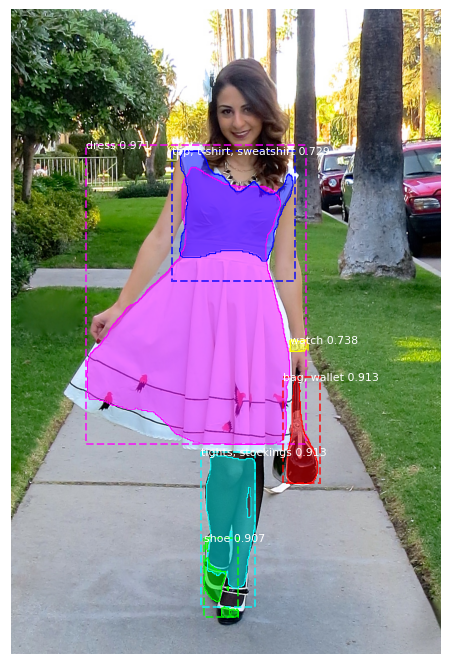

##Visualization after applying number of filters


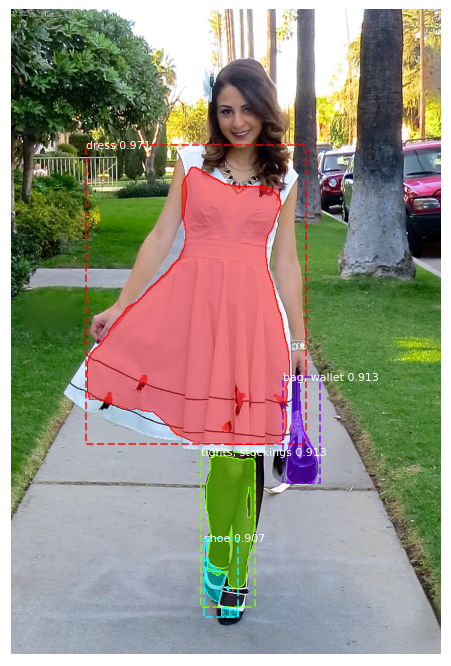

In [ ]:
im_path = 'test_image.jpg'
print(im_path)
img, rois, masks, class_ids, scores = get_inference_info(im_path)
img = img.astype('float32')

print('### Visualizing Mask RCNN output')
visualize.display_instances(img, rois, masks, class_ids, 
                            ['bg']+class_label, scores, figsize=(12, 12))

## Remove instances whose confidence score is less than 0.75
selected_indexes = []
for i, sco in enumerate(scores) :
    if sco > 0.75 : 
        selected_indexes.append(i)

rois_new = rois[selected_indexes]
masks_new = masks[:, :, selected_indexes]
class_ids_new = class_ids[selected_indexes]
scores_new = scores[selected_indexes]

### Remove the categories whose images to be recommended are not present in our dataset
selected_indexes = []
for indexx, cls in enumerate(class_ids_new) :
    if cls in class_id_list :
        selected_indexes.append(indexx)
   
rois_new = rois_new[selected_indexes]
masks_new = masks_new[:, :, selected_indexes]
class_ids_new = class_ids_new[selected_indexes]
scores_new = scores_new[selected_indexes]

## Remove the repeated instances keep the instance which has max confidece score
selected_indexes = []
maxx_dict = {}
for cls in class_ids_new :
    maxx_dict[cls] = (-1, -1)          #cls = (index, score)

for ind, (cls, score) in enumerate(zip(class_ids_new, scores_new)) :
    if maxx_dict[cls][1] < score :
        maxx_dict[cls] = (ind, score)  

for cls, info in maxx_dict.items() :
    selected_indexes.append(info[0])

selected_indexes = list(set(selected_indexes))
rois_new = rois_new[selected_indexes]
masks_new = masks_new[:, :, selected_indexes]
class_ids_new = class_ids_new[selected_indexes]
scores_new = scores_new[selected_indexes]
print('##Visualization after applying number of filters')
visualize.display_instances(img, rois_new, masks_new, class_ids_new, 
                            ['bg']+class_label, scores_new,
                            figsize=(12, 12))
img_original = img

CPU times: user 8.42 s, sys: 2.44 s, total: 10.9 s
Wall time: 11.4 s


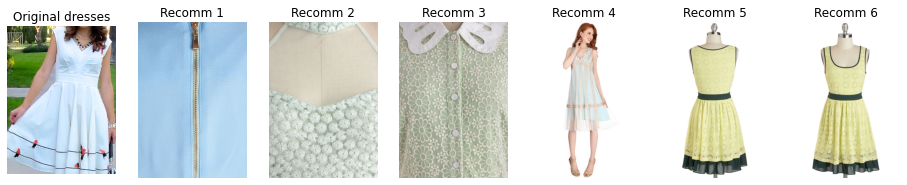

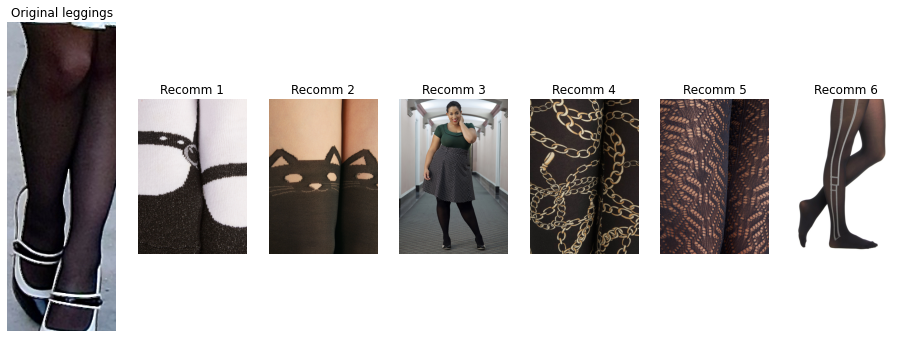

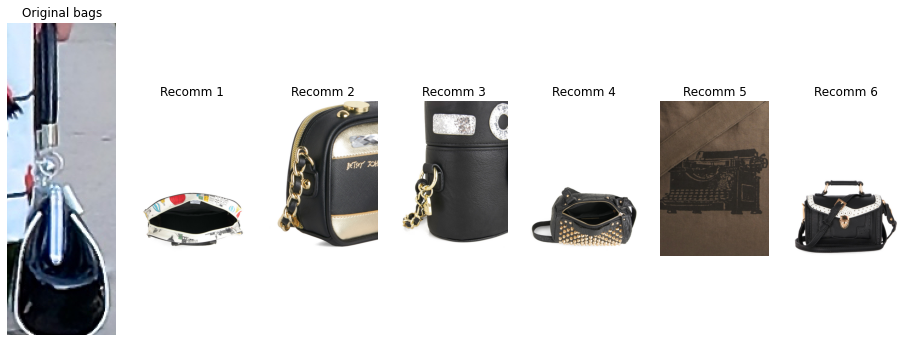

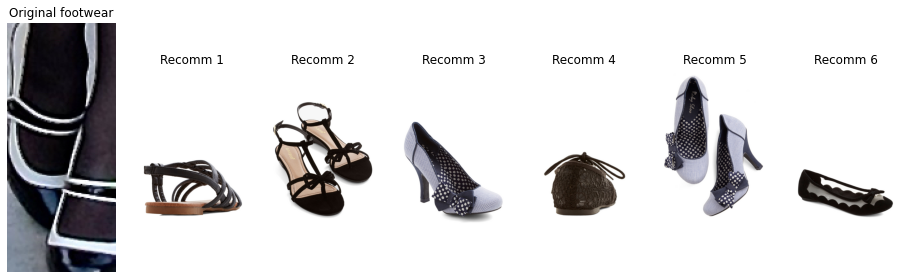

In [ ]:
%%time
topk = 6
IMAGE_SIZE1 = 256

def get_instance(img, bbox) :
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    return img[x1 : x2 + 1, y1 : y2 + 1, :]

anchor_array = []   ## for plotting
cats = []           ## categories
anchors_to_model = [] ## batch of anchor images for the triplet model

for i in range(len(class_ids_new)) :
    anchor = get_instance(img_original, rois_new[i])
    cat = class_mappings[class_ids_new[i]] 
    anchor_array.append(anchor)
    cats.append(cat)
    anchor = cv2.resize(anchor, (IMAGE_SIZE1, IMAGE_SIZE1), interpolation = cv2.INTER_NEAREST)
    anchors_to_model.append(anchor)

predictt = triplet_model.predict([np.stack(anchors_to_model), np.stack(anchors_to_model), np.stack(anchors_to_model)])
predictions = np.transpose(predictt, axes = [1, 0, 2])[0]
fast_download_df = pd.DataFrame({'class_id' : [], 'image_url' : []})

for i in range(len(class_ids_new)) :
    temp_df = embed_df[embed_df['category'] == cats[i]]
    v = predictions[i]
    similarity = temp_df['embeddings_new'].apply(lambda x: np.dot(v,x)/(np.linalg.norm(v)*np.linalg.norm(x)))
    nearestItemsIndex = similarity.sort_values(ascending=False).iloc[0:topk]
    nearestItems = temp_df.loc[nearestItemsIndex.index][['category', 'shop_photo_id']]
    for j, shop_id in enumerate(nearestItems['shop_photo_id'].values) :
        concat_df = pd.DataFrame([[int(i), shop_id_url[shop_id_url['shop_photo_id'] == shop_id]['shop_photo_url'].values[0]]], columns = fast_download_df.columns) 
        fast_download_df = pd.concat([fast_download_df, concat_df], axis = 0, ignore_index = True)

def optimized(args) :
    i, row = args
    img_url = row['image_url']
    path, _ = urllib.request.urlretrieve(img_url, 'temp_img_{}.jpg'.format(i))
    img1 = cv2.imread(path)
    img1 = cv2.cvtColor(img1, code = cv2.COLOR_BGR2RGB)
    row['image_obj'] = img1.astype(int)
    return row

pool = mp.Pool(processes = 16)
series_df = pool.map(optimized, [(i, row) for i, row in fast_download_df.iterrows()])
series_df = pd.concat(series_df, axis = 1)
series_df = series_df.T

for i in range(len(class_ids_new)) :
    fig, ax = plt.subplots(1, topk + 1, figsize = (16, 10))
    ax[0].imshow(anchor_array[i].astype(int))
    ax[0].axis('off')
    ax[0].set_title('Original {}'.format(cats[i]))
    for j, img1 in enumerate(series_df[series_df['class_id'] == i]['image_obj'].values):
        ax[j + 1].imshow(img1)
        ax[j + 1].axis('off')
        ax[j + 1].set_title('Recomm {}'.format(j + 1))
